Steps and files

1. Run the `estimate_loadshedding_schedule.ipynb` notebook to get the `loadshedding_pred.csv`
2. The rule thresholds can be adjusted in `det_loadshedding.py`
3. The accuracy of the estimated values in `loadshedding_pred.csv` can be calculated in `calculate_loadshedding_accuracy.ipynb` notebook
4. Install dotenv if you are using an environment variable to house your API Keys `pip install python-dotenv`
5. Import `get_data` function from `fetch_weather_data` and run the `get_data(city_name)` to fetch weather data from the specified city.
6. Import `weather_data.csv` and `loadshedding_pred.csv` to seperate pandas dataframe and merge them to create our models dataset in `model.ipynb`
7. Process new df formed, dropping unnecessay column names and slicing the dataset if necessary and start to build the model
8. Validate data using `validate_data.py`


In [1]:
# Fetch weather data from API
from fetch_weather_data import get_data

get_data(city="Cape Town")

Weather data saved to weather_data.csv from 2024-03-31 to 2024-03-31 for Cape Town.


In [ ]:
import pandas as pd
import numpy as nm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from data_ingestion import read_from_CSV

# Import data
pow_df = read_from_CSV("loadshedding_pred.csv")
weather_df = read_from_CSV("weather_data.csv")

# Check that the data to be merged are of the same size
N = len(pow_df.index) # Row count for loadshedding_pred df
weather_row_count = len(weather_df.index)  # Row count for weather df

# If the row count dont match raise an error
if weather_row_count != N:
    raise ValueError("Column length mismatch: ", weather_df.count().to_dict())

# Combine weather df and loadshedding df
df = pd.concat([pow_df, weather_df], axis=1)
df.head()

2025-02-17 05:27:30,966 - data_ingestion - INFO - CSV file read successfully from the path.
2025-02-17 05:27:30,980 - data_ingestion - INFO - CSV file read successfully from the path.


,date_time,estimated_loadshedding,timestamp,cape_town_temp,cape_town_humidity,cape_town_precipitation,cape_town_snow,cape_town_windspeed
0,2024-01-01 00:00:00,1,2024-01-01 00:00:00,21.7,68.95,0.0,0.0,14.8
1,2024-01-01 01:00:00,1,2024-01-01 01:00:00,21.1,71.91,0.0,0.0,13.0
2,2024-01-01 02:00:00,1,2024-01-01 02:00:00,22.6,60.76,0.0,0.0,16.5
3,2024-01-01 03:00:00,1,2024-01-01 03:00:00,21.0,68.81,0.0,0.0,5.4
4,2024-01-01 04:00:00,1,2024-01-01 04:00:00,19.1,76.84,0.0,0.0,11.2


Drop unwanted columns and check that the dataset does not contain null values

In [3]:
df = df.drop(["date_time", "timestamp"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   estimated_loadshedding   2184 non-null   int64  
 1   cape_town_temp           2184 non-null   float64
 2   cape_town_humidity       2184 non-null   float64
 3   cape_town_precipitation  2184 non-null   float64
 4   cape_town_snow           2184 non-null   float64
 5   cape_town_windspeed      2184 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 102.5 KB


Split dataset into Dependents and Independents, plot the countplot of the dependent
feature to get an idea of how our data is distributed

2025-02-17 06:42:16,538 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-17 06:42:16,557 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='estimated_loadshedding', ylabel='count'>

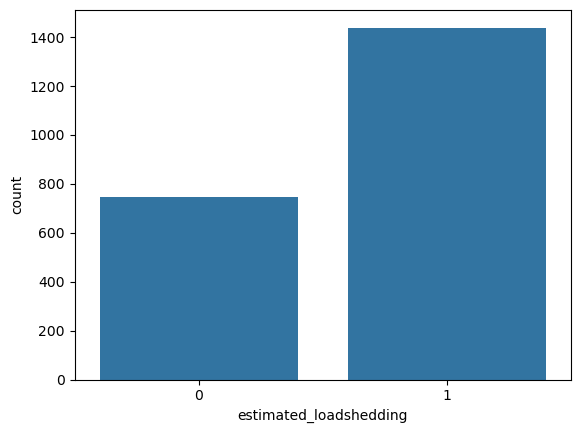

In [21]:
import seaborn as sns

X = df.drop("estimated_loadshedding", axis=1)
y = df["estimated_loadshedding"]

# Use seaborn to make a countplot
sns.countplot(x="estimated_loadshedding", data=df)

Split the dataset into training and testing

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get a count of our y test to see the distribution
y_test.value_counts()

estimated_loadshedding
1    286
0    151
Name: count, dtype: int64

Scale the X testing and training set

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Get a baseline metric for our calculation before hyperparameter tuning

In [40]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(n_estimators=100, random_state=42)
tree.fit(X_train_scaled, y_train)

pred_y = tree.predict(X_test_scaled)

Evaluate the acccuracy metrics of our model

In [60]:
print("Classification report for Loadshedding Model\n", classification_report(y_test, pred_y))
print("Confusion matrix for the loadshedding Model", confusion_matrix(y_test, pred_y))

Classification report for Loadshedding Model
               precision    recall  f1-score   support

           0       0.46      0.35      0.40       151
           1       0.70      0.79      0.74       286

    accuracy                           0.64       437
   macro avg       0.58      0.57      0.57       437
weighted avg       0.62      0.64      0.62       437

Confusion matrix for the loadshedding Model [[ 53  98]
 [ 61 225]]


Let's see if there's room to improve on these metrics using Hyperparameter Tuning

In [54]:
params = {
    "n_estimators": [1, 5, 10, 20, 50, 100, 150, 200],
    "min_samples_leaf": [1, 2],
    "max_depth": [1, 2, 3, 4, 5]
}

best_model = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
best_model.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [1, 5, 10, 20, 50, 100, 150, 200]})

In [58]:
model = best_model.best_estimator_
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [64]:
new_pred_y = model.predict(X_test_scaled)
print(classification_report(y_test, new_pred_y))
print(confusion_matrix(y_test, new_pred_y))

              precision    recall  f1-score   support

           0       0.47      0.05      0.10       151
           1       0.66      0.97      0.78       286

    accuracy                           0.65       437
   macro avg       0.57      0.51      0.44       437
weighted avg       0.59      0.65      0.55       437

[[  8 143]
 [  9 277]]
